In [1]:
import tensorflow_datasets as tfds
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from config import config


/home/siddhartha/fml/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-09 13:33:00.399531: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739125980.421281   14172 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739125980.427446   14172 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-09 13:33:00.448354: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical op

In [5]:

# 1. Load Wikipedia Data
def load_wikipedia_data(sample_size=config.sample_size):
    ds = tfds.load('wikipedia/20200301.en', split='train', shuffle_files=True)
    texts = []
    for example in ds.take(sample_size):  # Reduce for quick experimentation
        texts.append(example['text'].numpy().decode('utf-8'))
    return texts

# 2. Preprocess Data (simple version)
texts = load_wikipedia_data()


2025-02-09 12:59:39.315132: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:

# 3. Create Document Embeddings using BERT
embedder = SentenceTransformer('sentence-transformers/multi-qa-MiniLM-L6-dot-v1', device=config.device)
embeddings = embedder.encode(texts, show_progress_bar=True)

# 4. Cluster Topics with BERTopic
topic_model = BERTopic(embedding_model=embedder, min_topic_size=15)
topics, _ = topic_model.fit_transform(texts, embeddings)


Batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:07<00:00, 22.03it/s]


In [3]:

# 5. Create Knowledge Graph Nodes (Topics) - FIXED
topic_info = topic_model.get_topic_info()
filtered_topics = topic_info[topic_info['Topic'] != -1].copy()  # Filter out outliers
topic_embeddings = np.array([topic_model.topic_embeddings_[topic] 
                           for topic in filtered_topics['Topic']])

# 6. Calculate Cosine Similarity for Edges (unchanged)
similarity_matrix = cosine_similarity(topic_embeddings)


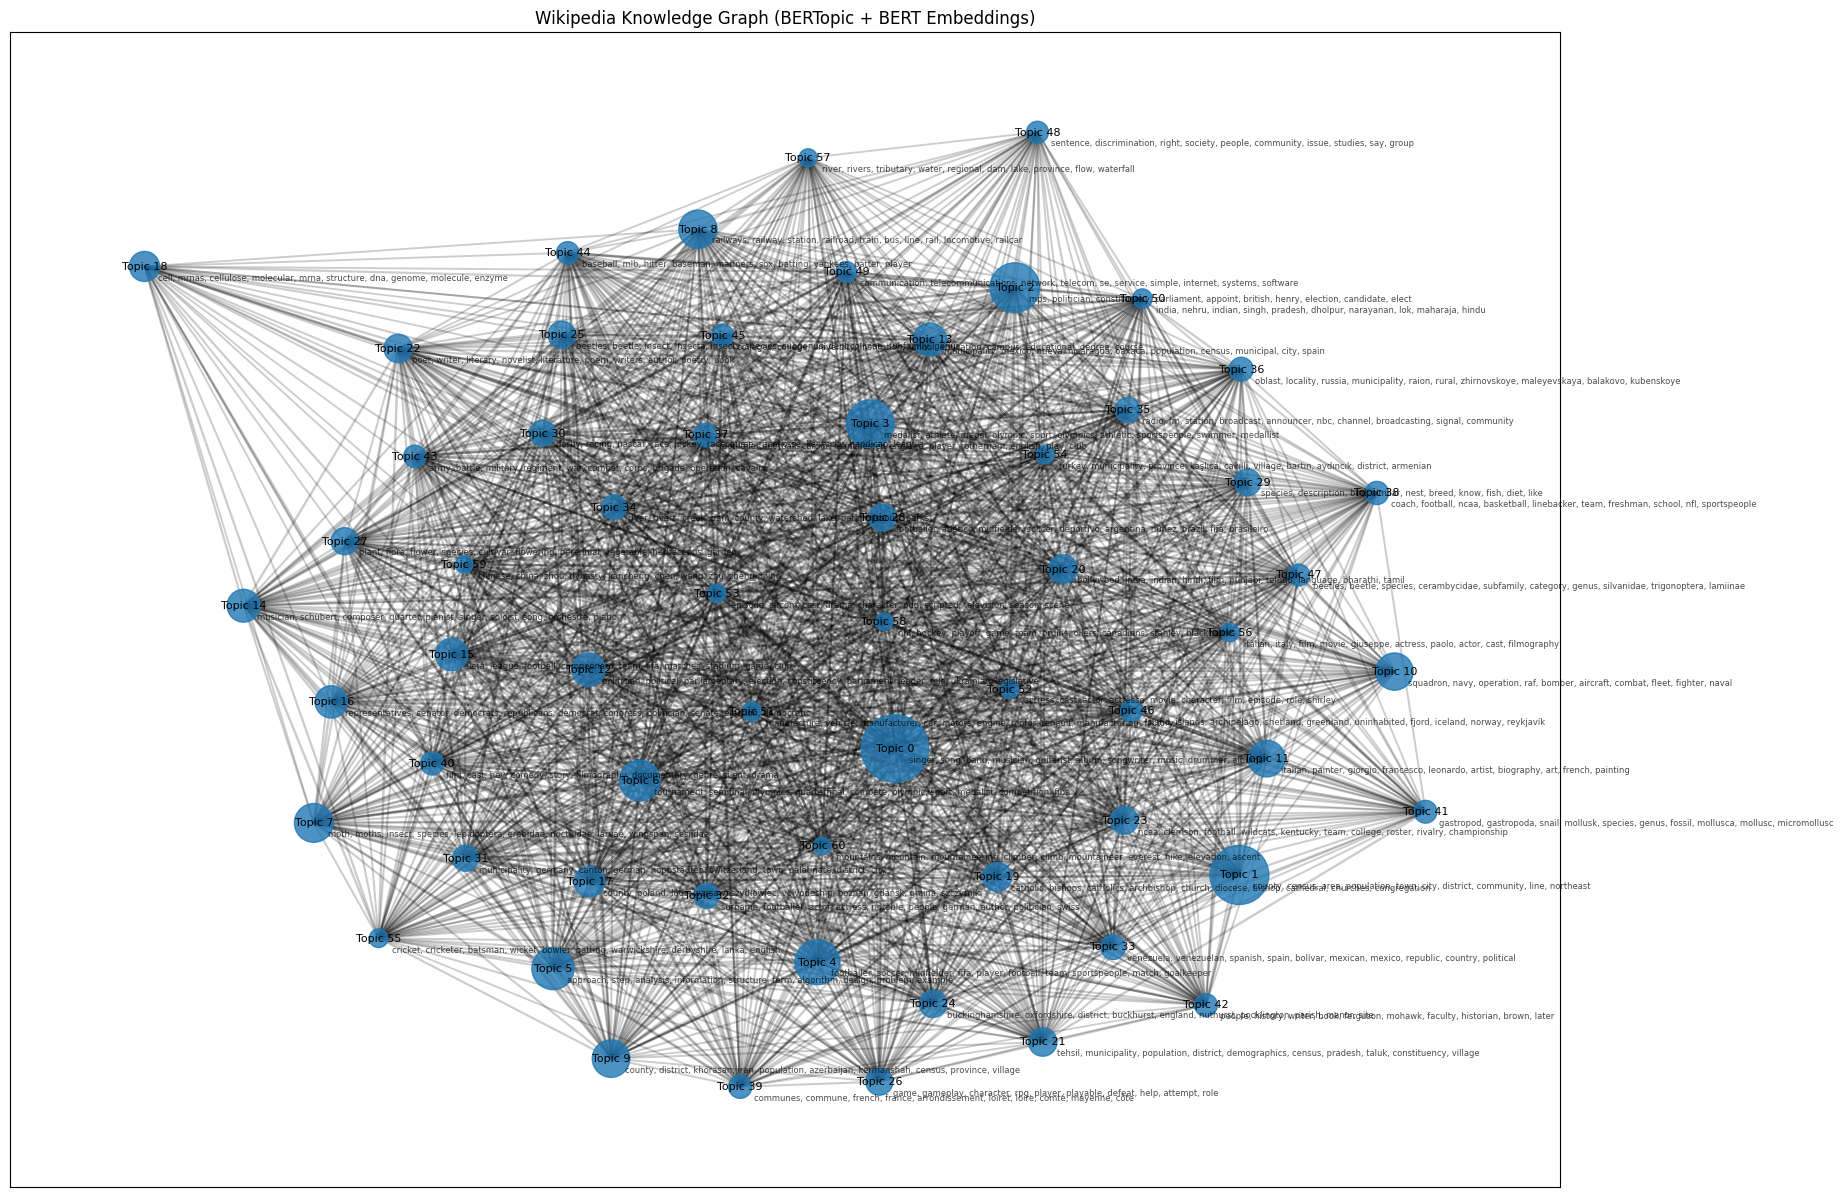

In [4]:

# 7. Build Graph - FIXED
G = nx.Graph()
threshold = 0.65

# Add nodes with metadata using FILTERED topics
for idx, row in filtered_topics.iterrows():
    G.add_node(row['Topic'],
               label=f"Topic {row['Topic']}",
               keywords=", ".join([word[0] for word in topic_model.get_topic(row['Topic'])]),
               size=row['Count'])  # Verify column name is 'Count'

# Add edges using FILTERED indices
for i in range(len(filtered_topics)):
    for j in range(i+1, len(filtered_topics)):
        if similarity_matrix[i][j] > threshold:
            G.add_edge(filtered_topics.iloc[i]['Topic'], 
                      filtered_topics.iloc[j]['Topic'],
                      weight=similarity_matrix[i][j])

# save graph
nx.write_graphml(G, 'my_graph.graphml')


# 8. Visualize Knowledge Graph
plt.figure(figsize=(20, 15))
pos = nx.spring_layout(G, k=0.5)

node_sizes = [G.nodes[node]['size']*10 for node in G.nodes]
edge_weights = [G.edges[edge]['weight']*2 for edge in G.edges]

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, alpha=0.8)
nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.2)
nx.draw_networkx_labels(G, pos, 
                        labels={node:G.nodes[node]['label'] for node in G.nodes},
                        font_size=8)

# Add keyword annotations
for node in G.nodes:
    plt.annotate(G.nodes[node]['keywords'], 
                 xy=pos[node], 
                 xytext=(10, -10),
                 textcoords='offset points',
                 fontsize=6,
                 alpha=0.7)

plt.title("Wikipedia Knowledge Graph (BERTopic + BERT Embeddings)")
plt.savefig("wikipedia_knowledge_graph.png")
plt.show()

In [5]:
topic_model_path = 'data/topic_model'
# load
topic_model = BERTopic.load(topic_model_path)

topic_model.get_topic_info()    # Get topic info



,Topic,Count,Name,Representation,Representative_Docs
0,-1,2104,-1_history_begin_english_war,"[history, begin, english, war, career, languag...",[Beach american post apocalyptic science ficti...
1,0,237,0_singer_song_band_musician,"[singer, song, band, musician, guitarist, albu...",[Velvet Underground american rock band form Ne...
2,1,180,1_county_census_area_population,"[county, census, area, population, town, city,...",[Stanley city Mountrail County North Dakota Un...
3,2,128,2_mps_politician_constituency_parliament,"[mps, politician, constituency, parliament, ap...",[Joseph Andrew Clarke September July canadian ...
4,3,119,3_medalist_athlete_medal_olympic,"[medalist, athlete, medal, olympic, sport, oly...",[David Lee Steen bear November canadian retire...
...,...,...,...,...,...
57,56,18,56_italian_italy_film_movie,"[italian, italy, film, movie, giuseppe, actres...",[Nanni Loy bear Giovanni Loi October August it...
58,57,17,57_river_rivers_tributary_water,"[river, rivers, tributary, water, regional, da...",[river North Korea have source Rangrim Mountai...
59,58,16,58_nhl_hockey_playoff_game,"[nhl, hockey, playoff, game, team, bruins, oil...",[Martin James Goal Game Barry December August ...
60,59,16,59_chinese_china_zhou_dynasty,"[chinese, china, zhou, dynasty, jiancheng, che...",[Qiū Hanyu Pinyin transliteration chinese fami...
